In [50]:
#instruction to be able to zoom on matplotlib figure
%matplotlib widget 


import sys
sys.path.insert(0,'/Users/chemon/ARGO_NEW/NEW_LOCODOX/locodox_python/source')
import os
import argopy
import xarray as xr
import glob
import numpy as np
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import seawater as sw
from datetime import date
import copy



# Import module for LOCODOX
from m_argo_data import open_argo_multi_profile_file, get_argo_launch_date, get_argo_optode_height, get_argo_data_for_WOA
from m_argo_data import get_argo_data_for_NCEP
from m_WOA_data import open_WOA_file, interp_WOA_on_ARGO
from m_NCEP_data import open_NCEP_file, interp_NCEP_on_ARGO, calcul_NCEP_PPOX
from m_NCEP_data import download_NCEP_if_needed
from m_users_fonctions import interp_pres_grid,O2stoO2p, O2ctoO2p, O2ptoO2c, O2ctoO2s,umolkg_to_umolL, diff_time_in_days, corr_data, copy_attr
from m_model_curve_fit import model_Gain, model_Gain_Derive, model_Gain_CarryOver, model_Gain_Derive_CarryOver, model_corr_pres
from m_users_plot import plot_WMO_position, plot_DOXY_QC, plot_QC_cycle, plot_DOXY_cycle, plot_ppox_Inair_Inwater_Ncep, plot_cmp_corr_NCEP, plot_cmp_corr_WOA
from m_users_plot import plot_cmp_ARGO_CTD, plot_cmp_corr_oxy_woa
from m_users_plot import plot_cmp_corr_NCEP_old, plot_cmp_corr_WOA_old
from m_read_write_netcdf import corr_file

In [51]:
#
# Init.
#

# plot or no ?
info_plot = 1 # 0 : some plots are not created, 1 : all plots

# WMO Float (string format)
num_float = '6902882' #'6903080'
first_cycle_to_use = 1
last_cycle_to_use = 400 #231 #71 # Cycle to use to estimate a correction

# Ctd comparison to estimate a supplement gain.
cmp_ctd = 1 # 1 if we used CTD for comparison, 0 otherwise
num_cycle = np.array([3]) # Cycle to compare to CTD
rep_ctd = ['/Volumes/lpo5/HYDROCEAN/MLT_NC/LPO/OVIDE/']
fic_ctd = ['ovid18_PRES.nc'] #['bo21_PRES.nc'] # Netcdf File with CTD
num_ctd = np.array([105]) 

# Do we correct data from a pressure effect ?
#corr_pres_effect = 1 # 1 if we estimate a correction effect pressure, 0 otherwise
pressure_threshold = 1500  # Pressure for pressure effect estimation. We use pressure > pressure_threshold

# ARGO directory : Directory where you can find 1 directory per WMO ARGO float.
# In the WMO float directory, you can find the Rtraj/Sprof/meta Netcdf Files and the 'profiles' subdirectory
# with the BR/BR and R/D files
#rep_data_argo = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/'
#rep_data_argo = '/Volumes/ref-argo/gdac/dac/coriolis/'
rep_data_argo = '/Volumes/ref-argo/gdac/dac/coriolis/'
#rep_data_argo = '/Users/chemon/ARGO_NEW/rinko_aanderaa/cmp_rinko_aanderaa/doxy_aanderaa/'

# The WOA file containing the WOA variables (doxywoa,Psatwoa/density/preswoa/PSAL_WOA/TEMP_WOA).
# Ex : doxywoa(time,Depth,lat,lon) with time=12,lat=180,lon=360,Depth=102 : contains the monthly average of doxy
# this file is created by an internal LOPS routine.
#
fic_WOA = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/WOA/WOA2018_DECAV_monthly_5500_1deg.nc'

# which variable to used :
# which_var = 1 : RAW Data
# which_var = 2 : Adjusted Data
# which_var = 3 : Adjusted Data if available, otherwise Raw Data
which_var = 2

#
# Which PSAT to used :
# which_psat = 1 : We use PSAT from WOA file
# which_psat = 2 We use PSAT calculated as Locodox
which_psat = 2
# Min and Max pressure to average WOA and ARGO PPOX
min_pres_interp = 0
max_pres_interp = 25

# Which QC used for pressure, temperature, salinity and oxygen.
# In Sprof, we got interpolated data (flag=8)
pres_qc = [1,2,8]
temp_qc = [1,2,8]
sal_qc = [1,2,8]
doxy_qc = [1,2,3,8]

# NCEP directory : where the NCEP slp/air.sig995/rhum.sig995 can be found or downloaded if needed
rep_NCEP_data= '/Users/chemon/ARGO_NEW/NEW_LOCODOX/NCEP_DATA/'
# NCEP ftp server
ftp_server = 'ftp.cdc.noaa.gov'
# Ncep ftp directory
rep_ftp = 'Datasets/ncep.reanalysis/surface'
# NCEP variables needed.
ncep_variables = ['slp','air.sig995','rhum.sig995']

# ARGO InAir code
code_inair = [699,711,799]
# Argo InWater code
code_inwater = [690,710]
# Min and max pressure to extract the salinity for inwater data (because for inwater data, the pump is off.
# So, we decided to take the salinity from the profile (with the pump on).
min_pres = 0
max_pres = 10

percent_relative_error = 2.0

In [52]:
# Read ARGO files 
ds_argo_meta = open_argo_multi_profile_file(num_float,rep_data_argo,'meta')
ds_argo_Sprof = open_argo_multi_profile_file(num_float,rep_data_argo,'Sprof')
ds_argo_Rtraj = open_argo_multi_profile_file(num_float,rep_data_argo,'Rtraj')

/Volumes/ref-argo/gdac/dac/coriolis/6902882/6902882_meta.nc
/Volumes/ref-argo/gdac/dac/coriolis/6902882/6902882_Sprof.nc
/Volumes/ref-argo/gdac/dac/coriolis/6902882/6902882_Rtraj.nc


In [53]:
# Select the cycles to be used
ds_argo_Sprof = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']>=first_cycle_to_use) & (ds_argo_Sprof['CYCLE_NUMBER']<=last_cycle_to_use),drop=True)
ds_argo_Rtraj = ds_argo_Rtraj.where( (ds_argo_Rtraj['CYCLE_NUMBER']>=first_cycle_to_use) & (ds_argo_Rtraj['CYCLE_NUMBER']<=last_cycle_to_use),drop=True)
ds_argo_Sprof['PLATFORM_NUMBER'] = ds_argo_Sprof['PLATFORM_NUMBER'].astype(int) # The where transform the nan from int to float ...

In [54]:
ds_argo_Sprof

<xarray.Dataset> Size: 35MB
Dimensions:                       (N_PROF: 154, N_PARAM: 4, N_CALIB: 2,
                                   N_LEVELS: 1813)
Dimensions without coordinates: N_PROF, N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/58)
    DATA_TYPE                     (N_PROF) object 1kB 'Argo synthetic profile...
    FORMAT_VERSION                (N_PROF) object 1kB '1.0 ' '1.0 ' ... '1.0 '
    HANDBOOK_VERSION              (N_PROF) object 1kB '1.2 ' '1.2 ' ... '1.2 '
    REFERENCE_DATE_TIME           (N_PROF) datetime64[ns] 1kB 1950-01-01 ... ...
    DATE_CREATION                 (N_PROF) datetime64[ns] 1kB 2024-12-13T12:2...
    DATE_UPDATE                   (N_PROF) datetime64[ns] 1kB 2024-12-13T12:2...
    ...                            ...
    DOXY                          (N_PROF, N_LEVELS) float32 1MB 291.7 ... nan
    DOXY_QC                       (N_PROF, N_LEVELS) float64 2MB 3.0 0.0 ... 0.0
    DOXY_dPRES                    (N_PROF, N_LEVELS) float32 1MB 0.0 nan ... nan
    DOXY_ADJUSTED                 (N_PROF, N_LEVELS) float32 1MB nan nan ... nan
    DOXY_ADJUSTED_QC              (N_PROF, N_LEVELS) float64 2MB 4.0 0.0 ... 0.0
    DOXY_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 1MB nan nan ... nan
Attributes:
    title:                Argo float vertical profile
    institution:          CORIOLIS
    source:               Argo float
    history:              2024-12-13T12:24:23Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.18 (version 11.01.2024 for ARGO_simplified_profile)
    id:                   https://doi.org/10.17882/42182

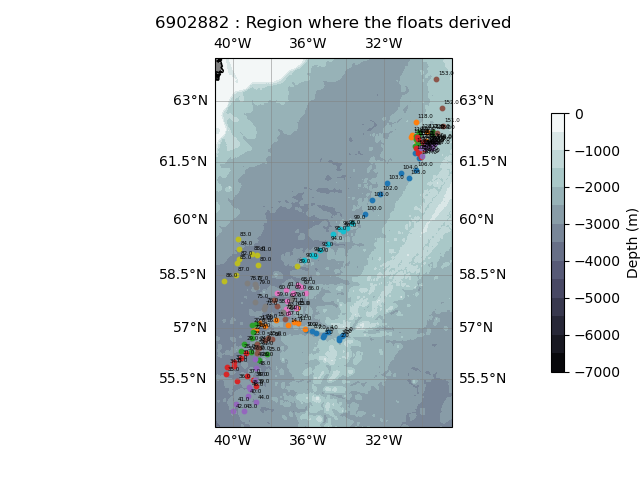

In [55]:
#Maps plotting
if info_plot==1:
    fic_bathy = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/TOPOGRAPHY/ETOPO2v2c_f4.nc'
    ds_bathy = xr.open_dataset(fic_bathy)

    extend_lon_lat = 0.5
    depths = np.arange(-7000,500,500)
    plot_WMO_position(ds_argo_Sprof, ds_bathy, depths,extend_lon_lat)

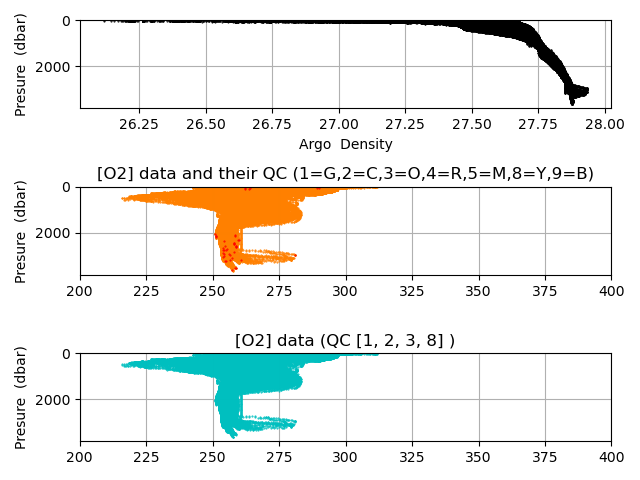

In [56]:
# DOXY_QC plot with PRES/PSAL/TEMP
if info_plot==1:
    plot_DOXY_QC(ds_argo_Sprof,doxy_qc)

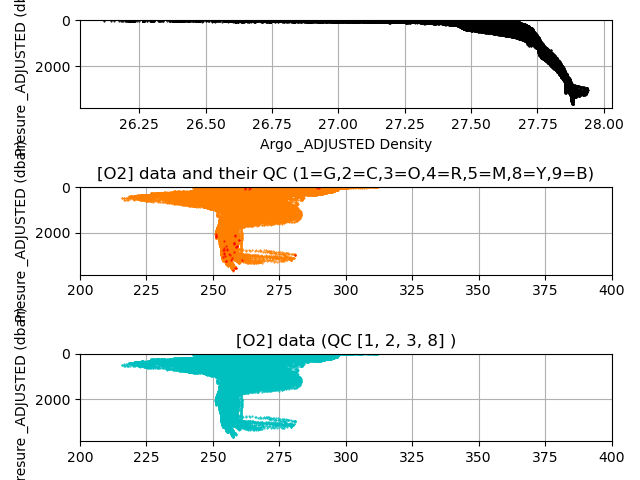

In [57]:
# Same with DATA ADJUSTED (PRES,PSAM,TEMP)
if info_plot==1:
    plot_DOXY_QC(ds_argo_Sprof,doxy_qc,'_ADJUSTED')

PRES
TEMP
PSAL


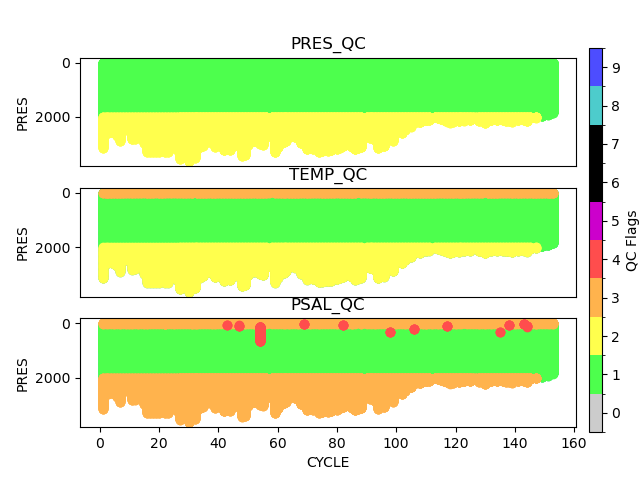

In [58]:
# PRES/PSAL/TEMP QC
if info_plot==1:
    plot_QC_cycle(ds_argo_Sprof)

PRES_ADJUSTED
TEMP_ADJUSTED
PSAL_ADJUSTED


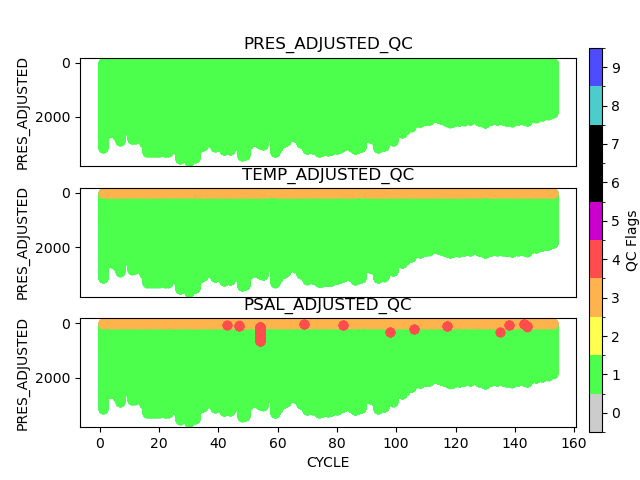

In [59]:
# Same with adjusted DATA
if info_plot==1:
    plot_QC_cycle(ds_argo_Sprof,'_ADJUSTED')

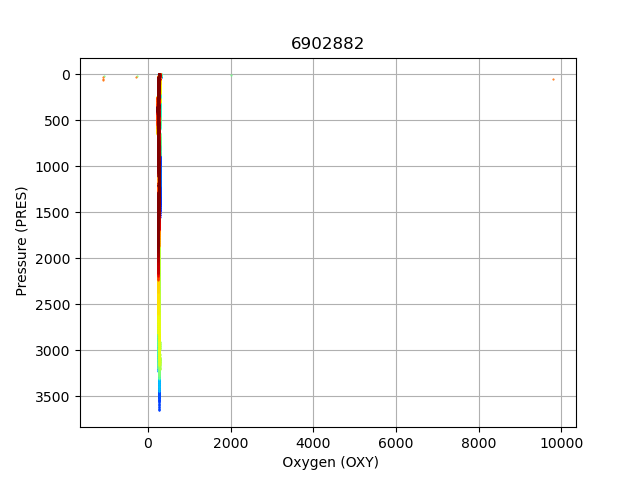

In [60]:
# DOXY RAW DATA
_=plot_DOXY_cycle(ds_argo_Sprof)

In [61]:
# Lauch data
launch_date = get_argo_launch_date(ds_argo_meta)
print(launch_date)
optode_height = get_argo_optode_height(ds_argo_meta)
print(optode_height)

2018-07-08T15:33:00.000000000
-0.3


In [62]:
# Delta time from laucnh date
delta_T_sprof = diff_time_in_days(ds_argo_Sprof['JULD'],launch_date)


In [63]:
delta_T_sprof

<xarray.DataArray 'JULD' (N_PROF: 154)> Size: 1kB
array([8.81944444e-02, 1.33078704e+00, 1.07586806e+01, 2.07995370e+01,
       3.07267361e+01, 4.08175926e+01, 5.08642361e+01, 6.09259259e+01,
       7.06079861e+01, 8.07620370e+01, 9.05711806e+01, 1.00900926e+02,
       1.10913542e+02, 1.20828009e+02, 1.30822569e+02, 1.40980787e+02,
       1.51089931e+02, 1.61105093e+02, 1.71102431e+02, 1.81096065e+02,
       1.91080903e+02, 2.00986343e+02, 2.11085069e+02, 2.21100926e+02,
       2.30948958e+02, 2.40905903e+02, 2.51028819e+02, 2.61161458e+02,
       2.70914931e+02, 2.81000347e+02, 2.91215625e+02, 3.01172569e+02,
       3.11171181e+02, 3.20969792e+02, 3.31023264e+02, 3.40982986e+02,
       3.50871181e+02, 3.60942708e+02, 3.70940625e+02, 3.81029514e+02,
       3.90889931e+02, 4.00916319e+02, 4.11071875e+02, 4.20885764e+02,
       4.31047569e+02, 4.41101736e+02, 4.50987847e+02, 4.60919097e+02,
       4.71139931e+02, 4.81126736e+02, 4.90975347e+02, 5.00938542e+02,
       5.10931597e+02, 5.20888542e+02, 5.30965625e+02, 5.40984375e+02,
       5.50853125e+02, 5.61644097e+02, 5.70855208e+02, 5.81084375e+02,
       5.91017014e+02, 6.00905903e+02, 6.10948264e+02, 6.20924653e+02,
       6.30842708e+02, 6.40824653e+02, 6.50878819e+02, 6.60799653e+02,
       6.70957986e+02, 6.80726042e+02, 6.91050347e+02, 7.00846181e+02,
       7.11039236e+02, 7.21017014e+02, 7.31082986e+02, 7.41078819e+02,
       7.51073958e+02, 7.61068403e+02, 7.71090625e+02, 7.80989931e+02,
       7.91048264e+02, 8.01027431e+02, 8.11022569e+02, 8.20964931e+02,
       8.30992014e+02, 8.41014236e+02, 8.51038542e+02, 8.61025347e+02,
       8.71016319e+02, 8.81644097e+02, 8.90820486e+02, 9.00884375e+02,
       9.10883681e+02, 9.20904514e+02, 9.31021875e+02, 9.40831597e+02,
       9.51012847e+02, 9.60919792e+02, 9.70801042e+02, 9.80912847e+02,
       9.90750347e+02, 1.00077743e+03, 1.01081493e+03, 1.02076146e+03,
       1.03069549e+03, 1.04073368e+03, 1.05063368e+03, 1.06070937e+03,
       1.07065799e+03, 1.08062743e+03, 1.09065868e+03, 1.10061424e+03,
       1.11059340e+03, 1.12063021e+03, 1.13065104e+03, 1.14061354e+03,
       1.15061424e+03, 1.16064271e+03, 1.17065521e+03, 1.18065104e+03,
       1.19060868e+03, 1.20064479e+03, 1.21062535e+03, 1.22063090e+03,
       1.23063229e+03, 1.24061632e+03, 1.25061562e+03, 1.26062535e+03,
       1.27068715e+03, 1.28066424e+03, 1.29065937e+03, 1.30062465e+03,
       1.31067049e+03, 1.32065451e+03, 1.33067118e+03, 1.34060868e+03,
       1.35066354e+03, 1.36067049e+03, 1.37063993e+03, 1.38065590e+03,
       1.39061007e+03, 1.40061632e+03, 1.41061285e+03, 1.42062049e+03,
       1.43064549e+03, 1.44061424e+03, 1.45059410e+03, 1.46062674e+03,
       1.47061910e+03, 1.48066424e+03, 1.49061424e+03, 1.50062049e+03,
       1.51062326e+03, 1.52062118e+03])
Dimensions without coordinates: N_PROF

In [64]:
# ARGO data needed for WOA correction
ds_argo = get_argo_data_for_WOA(ds_argo_Sprof,pres_qc,temp_qc,sal_qc,doxy_qc,which_var)

PSAL ADJUSTED Data Used
PRES ADJUSTED Data Used
TEMP ADJUSTED Data Used


In [65]:
delta_T_WOA = diff_time_in_days(ds_argo['JULD'].values,launch_date)

In [66]:
ds_woa = open_WOA_file(fic_WOA)
ds_woa

We force Longitude in [-180 180]


<xarray.Dataset> Size: 4GB
Dimensions:    (lat: 180, lon: 360, N_LEVELS: 102, time: 12)
Coordinates:
  * Depth      (N_LEVELS) float64 816B 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time       (time) float64 96B 15.0 46.0 75.0 106.0 ... 289.0 320.0 350.0
Dimensions without coordinates: lat, lon, N_LEVELS
Data variables:
    latitude   (lat) float64 1kB ...
    longitude  (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... -3.5 -2.5 -1.5 -0.5
    doxywoa    (time, N_LEVELS, lat, lon) float64 635MB ...
    Psatwoa    (time, N_LEVELS, lat, lon) float64 635MB ...
    density    (time, N_LEVELS, lat, lon) float64 635MB ...
    preswoa    (time, N_LEVELS, lat, lon) float64 635MB ...
    PSAL_WOA   (time, N_LEVELS, lat, lon) float64 635MB ...
    TEMP_WOA   (time, N_LEVELS, lat, lon) float64 635MB ...

In [67]:
# Interp WOA data on ARGO time
ds_woa_interp_on_ARGO = interp_WOA_on_ARGO(ds_woa, ds_argo)

WOA time Extrapolation for interpolation

<xarray.Dataset> Size: 4GB
Dimensions:   (lat: 180, lon: 360, N_LEVELS: 102, time: 14)
Coordinates:
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... -4.5 -3.5 -2.5 -1.5 -0.5
  * Depth     (N_LEVELS) float64 816B 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time      (time) float64 112B -15.25 15.0 46.0 75.0 ... 320.0 350.0 380.2
Dimensions without coordinates: N_LEVELS
Data variables:
    doxywoa   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    Psatwoa   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    density   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    preswoa   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    PSAL_WOA  (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    TEMP_WOA  (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
101.86589

In [68]:
# Interpolation WOA et ARGO on regular grid (defined at the beginning)

var_to_interpol = [var for var in ds_woa_interp_on_ARGO.data_vars if "N_LEVELS" in ds_woa_interp_on_ARGO[var].dims]
ds_woa_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_woa_interp_on_ARGO,'preswoa','Depth')

var_to_interpol = [var for var in ds_argo.data_vars if "N_LEVELS" in ds_argo[var].dims]
ds_argo_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_argo,'PRES_ARGO','N_LEVELS')

Interpolation variable doxywoa on a regular pressure grid
Interpolation variable Psatwoa on a regular pressure grid
Interpolation variable density on a regular pressure grid
Interpolation variable preswoa on a regular pressure grid
Interpolation variable PSAL_WOA on a regular pressure grid
Interpolation variable TEMP_WOA on a regular pressure grid
Interpolation variable TEMP_ARGO on a regular pressure grid
Interpolation variable TEMP_ARGO_QC on a regular pressure grid
Interpolation variable PSAL_ARGO on a regular pressure grid
Interpolation variable PSAL_ARGO_QC on a regular pressure grid
Interpolation variable DOXY_ARGO on a regular pressure grid
Interpolation variable DOXY_ARGO_QC on a regular pressure grid
Interpolation variable PRES_ARGO on a regular pressure grid
Interpolation variable PRES_ARGO_QC on a regular pressure grid


In [69]:
# Add attributes in data interp 
ds_argo_interp = copy_attr(ds_argo,ds_argo_interp)
ds_woa_interp = copy_attr(ds_woa_interp_on_ARGO,ds_woa_interp)

In [70]:
# PPOX WOA.
ppox_WOA = O2stoO2p(ds_woa_interp['Psatwoa'],ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) 
ppox_WOA_mean = np.nanmean(ppox_WOA,axis=1)

We calculate PSAT as Locodox Matlab does


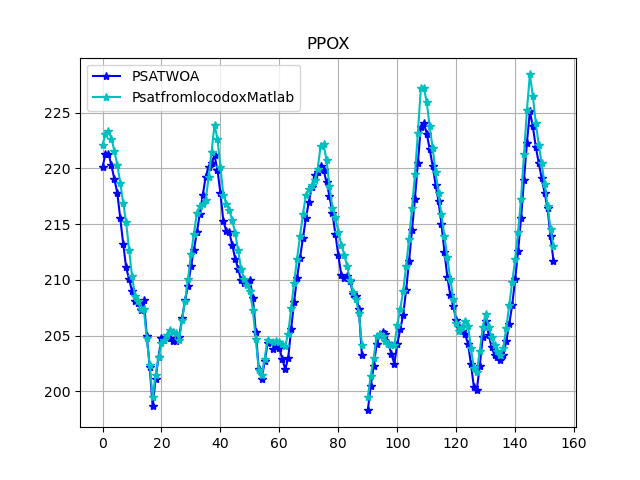

In [71]:
# Do we compute psatWOA as locodox matlab ?
if which_psat == 2:
    print('We calculate PSAT as Locodox Matlab does')
    ana_dens_woa = sw.pden(ds_woa_interp['PSAL_WOA'],ds_woa_interp['TEMP_WOA'],np.arange(min_pres_interp,max_pres_interp+1,1),0)
    O2_ARGO_umolL = umolkg_to_umolL(ds_woa_interp['doxywoa'],ds_argo['DOXY_ARGO'].units,ana_dens_woa)
    psatwoaV2 = O2ctoO2s(O2_ARGO_umolL,ds_woa_interp['TEMP_WOA'],ds_woa_interp['PSAL_WOA'])
    ppox_WOA2 = O2stoO2p(psatwoaV2,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) 
    ppox_WOA_mean2 = np.nanmean(ppox_WOA2,axis=1)

    plt.figure()
    plt.plot(ppox_WOA_mean,'*-b')
    plt.plot(ppox_WOA_mean2,'*-c')
    plt.grid()
    plt.title('PPOX')
    plt.legend(['PSATWOA','PsatfromlocodoxMatlab'])
    ppox_WOA_mean = ppox_WOA_mean2

In [72]:
# PPOX ARGO
ana_dens = sw.pden(ds_argo_interp['PSAL_ARGO'],ds_argo_interp['TEMP_ARGO'],np.arange(min_pres_interp,max_pres_interp+1,1),0)
O2_ARGO_umolL = umolkg_to_umolL(ds_argo_interp['DOXY_ARGO'],ds_argo['DOXY_ARGO'].units,ana_dens)

ppox_ARGO = O2ctoO2p(O2_ARGO_umolL,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) # On calcule PPOX pour P=0
ppox_ARGO_mean = np.nanmean(ppox_ARGO,axis=1)

In [73]:
# Correction : Gain estimation
initial_guess = 1  # Valeurs initiales pour G 
params_Gain_WOA, covariance = curve_fit(model_Gain, ppox_ARGO_mean/ppox_ARGO_mean, ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit')


In [74]:
# Correction : Gain and Drift Time estimation
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_WOA, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [ppox_ARGO_mean/ppox_ARGO_mean,delta_T_WOA], ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit',full_output=True)

In [75]:
# NCEP Correction
# Download NCEP Data
download_NCEP_if_needed(ds_argo_Sprof['JULD'],ftp_server,rep_ftp,rep_NCEP_data,ncep_variables)
#annee_to_download = [min(ds_argo['JULD'].dt.year).values,max(ds_argo['JULD'].dt.year).values]
#download_NCEP_force(annee_to_download,ftp_server,rep_ftp,rep_NCEP_data,ncep_variables)

File slp.2018.nc already exists with the same size. No Download
File air.sig995.2018.nc already exists with the same size. No Download
File rhum.sig995.2018.nc already exists with the same size. No Download
File slp.2019.nc already exists with the same size. No Download
File air.sig995.2019.nc already exists with the same size. No Download
File rhum.sig995.2019.nc already exists with the same size. No Download
File slp.2020.nc already exists with the same size. No Download
File air.sig995.2020.nc already exists with the same size. No Download
File rhum.sig995.2020.nc already exists with the same size. No Download
File slp.2021.nc already exists with the same size. No Download
File air.sig995.2021.nc already exists with the same size. No Download
File rhum.sig995.2021.nc already exists with the same size. No Download
File slp.2022.nc already exists with the same size. No Download
File air.sig995.2022.nc already exists with the same size. No Download
File rhum.sig995.2022.nc already exis

In [76]:
ds_argo_Rtraj

<xarray.Dataset> Size: 2GB
Dimensions:                              (N_MEASUREMENT: 44581, N_PARAM: 8,
                                          N_CYCLE: 154, N_CALIB_PARAM: 3,
                                          N_CALIB_JULD: 1, N_HISTORY: 3)
Dimensions without coordinates: N_MEASUREMENT, N_PARAM, N_CYCLE, N_CALIB_PARAM,
                                N_CALIB_JULD, N_HISTORY
Data variables: (12/129)
    DATA_TYPE                            (N_MEASUREMENT) object 357kB 'Argo t...
    FORMAT_VERSION                       (N_MEASUREMENT) object 357kB '3.2 ' ...
    HANDBOOK_VERSION                     (N_MEASUREMENT) object 357kB '1.2 ' ...
    REFERENCE_DATE_TIME                  (N_MEASUREMENT) datetime64[ns] 357kB ...
    DATE_CREATION                        (N_MEASUREMENT) datetime64[ns] 357kB ...
    DATE_UPDATE                          (N_MEASUREMENT) datetime64[ns] 357kB ...
    ...                                   ...
    HISTORY_PARAMETER                    (N_HISTORY, N_MEASUREMENT) object 1MB ...
    HISTORY_PREVIOUS_VALUE               (N_HISTORY, N_MEASUREMENT) float32 535kB ...
    HISTORY_INDEX_DIMENSION              (N_HISTORY, N_MEASUREMENT) object 1MB ...
    HISTORY_START_INDEX                  (N_HISTORY, N_MEASUREMENT) float64 1MB ...
    HISTORY_STOP_INDEX                   (N_HISTORY, N_MEASUREMENT) float64 1MB ...
    HISTORY_QCTEST                       (N_HISTORY, N_MEASUREMENT) object 1MB ...
Attributes:
    title:                        Argo float trajectory file
    institution:                  CORIOLIS
    source:                       Argo float
    history:                      2024-11-27T16:12:21Z creation; 2024-11-27T1...
    references:                   http://www.argodatamgt.org/Documentation
    user_manual_version:          3.4
    Conventions:                  Argo-3.2 CF-1.6
    featureType:                  trajectory
    decoder_version:              CODA_070f
    id:                           https://doi.org/10.17882/42182
    comment_on_resolution:        JULD and PRES variable resolutions depend o...
    comment_on_measurement_code:  Meaning of some specific measurement codes ...

We look for PSAL in Sprof near the surface between 0 and 10
We look for PSAL_ADJUSTED in Sprof near the surface between 0 and 10


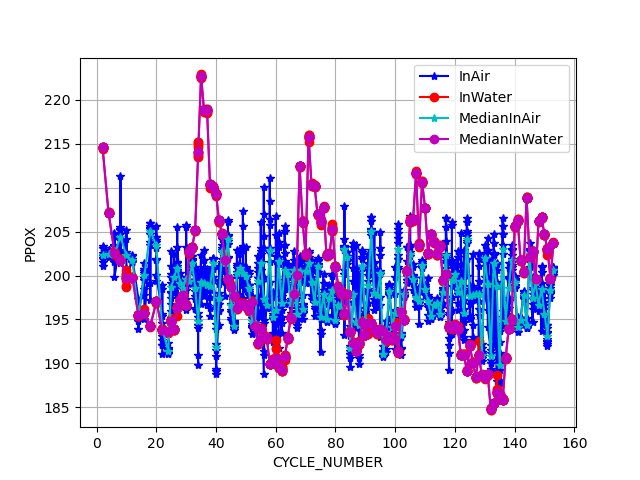

PSAL_ADJUSTED Data is used


In [77]:
# Get ARGO PPOX inair/inwater
dsair,dsinwater = get_argo_data_for_NCEP(ds_argo_Rtraj,ds_argo_Sprof,which_var,code_inair,code_inwater,min_pres,max_pres)

In [78]:
dsinwater['CYCLE_NUMBER']

<xarray.DataArray 'CYCLE_NUMBER' (CYCLE_NUMBER: 141)> Size: 1kB
array([  2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,
        37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,
        49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
        61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,
        73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,
        85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,
        97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107., 108.,
       109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143., 144.,
       145., 146., 147., 148., 149., 150., 151., 152., 153.])
Coordinates:
  * CYCLE_NUMBER  (CYCLE_NUMBER) float64 1kB 2.0 4.0 6.0 ... 151.0 152.0 153.0
Attributes:
    long_name:    Float cycle number of the measurement
    conventions:  0...N, 0 : launch cycle, 1 : first complete cycle
    casted:       1

In [79]:
# Compute NCEP data at ARGO time
ds_NCEP_air,ds_NCEP_rhum, ds_NCEP_slp = open_NCEP_file(rep_NCEP_data)
ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp = interp_NCEP_on_ARGO(ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp,dsair['LONGITUDE_ARGO'],dsair['LATITUDE_ARGO'],dsair['JULD'])
z0q = 1e-4
NCEP_PPOX = calcul_NCEP_PPOX(dsinwater,ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp,optode_height,z0q)

In [80]:
delta_T_NCEP = diff_time_in_days(dsair['JULD'].values,launch_date)

In [81]:
delta_T_NCEP

array([  10.77533565,   30.74315972,   50.88092593,   70.62440972,
         90.58741898,  110.92991898,  130.83893519,  151.10625   ,
        171.1190625 ,  191.0972338 ,  211.10175926,  230.96559028,
        240.92236111,  251.04511574,  261.17822917,  270.93163194,
        281.01702546,  291.23217593,  301.1890625 ,  311.18792824,
        320.98658565,  331.03993056,  340.9996875 ,  350.88790509,
        360.95925926,  370.95731481,  381.04597222,  390.90609954,
        400.93255787,  411.08856481,  420.90190972,  431.06422454,
        441.11788194,  451.00400463,  460.93537037,  471.15612269,
        481.14319444,  490.99164352,  500.95523148,  510.94819444,
        520.9047338 ,  530.98228009,  541.00104167,  550.86972222,
        561.66030093,  570.87150463,  581.10069444,  591.03332176,
        600.92237269,  610.96460648,  620.9409838 ,  630.85931713,
        640.84141204,  650.8953588 ,  660.81646991,  670.97422454,
        680.7425463 ,  691.0666088 ,  700.86290509,  711.05590

In [82]:
# Correction with NCEP without CarryOver
PPOX1 = dsair['PPOX_DOXY'].values
PPOX2 = dsinwater['PPOX_DOXY'].values
initial_guess = 1
params_Gain_NCEP, covariance,info,mesg,ier = curve_fit(model_Gain, PPOX1/PPOX1, NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit',full_output=True)
print(params_Gain_NCEP)
#print(info)
perr_Gain_NCEP = np.sqrt(np.diag(covariance))
print(perr_Gain_NCEP)


initial_guess = [1, 0]  # Valeurs initiales pour G et C
params_Gain_NCEP_CarryOver, covariance = curve_fit(model_Gain_CarryOver, [PPOX1,PPOX2], NCEP_PPOX, p0=initial_guess,nan_policy='omit')
print(params_Gain_NCEP_CarryOver)
perr_Gain_NCEP_CarryOver = np.sqrt(np.diag(covariance))
print(perr_Gain_NCEP_CarryOver)

[1.05214861]
[0.00116719]
[ 1.05159009 -0.14500217]
[0.00108536 0.03401422]


In [83]:
# Correction with NCEP with CarryOver
initial_guess = [1, 0]  # Valeurs initiales pour G/D
params_Gain_Derive_NCEP, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [PPOX1/PPOX1,delta_T_NCEP], NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit',full_output=True)
#params_Gain_Derive_NCEP, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [PPOX1,delta_T_NCEP], NCEP_PPOX, p0=initial_guess,nan_policy='omit',full_output=True)
#params_Gain_Derive_NCEP, covariance = curve_fit(model_Gain_Derive, [PPOX1/PPOX1,delta_T_NCEP], NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit')
print(params_Gain_Derive_NCEP)
perr_Gain_Derive_NCEP = np.sqrt(np.diag(covariance))
print(perr_Gain_Derive_NCEP)
initial_guess = [1, 0, 0]  # Valeurs initiales pour G/C/D
params_Gain_Derive_NCEP_CarryOver, covariance = curve_fit(model_Gain_Derive_CarryOver, [PPOX1,PPOX2,delta_T_NCEP], NCEP_PPOX, p0=initial_guess,nan_policy='omit')
print(params_Gain_Derive_NCEP_CarryOver)
perr_Gain_Derive_NCEP_CarryOver = np.sqrt(np.diag(covariance))
print(perr_Gain_Derive_NCEP_CarryOver)

[1.04189742 0.43926756]
[0.00238185 0.09180251]
[ 1.04015606 -0.16326345  0.49142909]
[0.0021257  0.03144563 0.08225085]


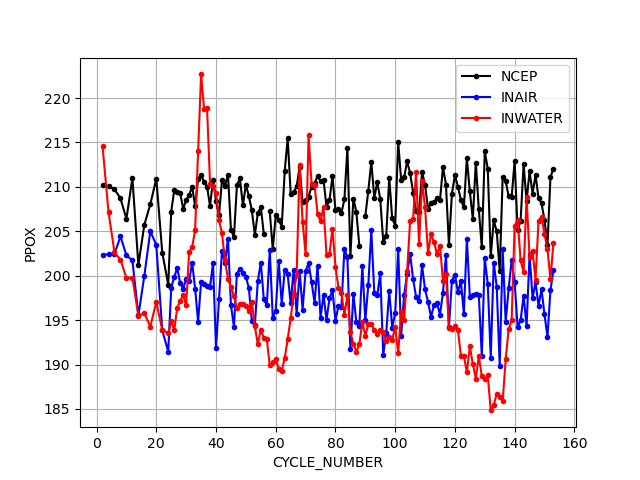

In [84]:
# Plot NCEP and ARGO PPOX
_ = plot_ppox_Inair_Inwater_Ncep(dsair,dsinwater,NCEP_PPOX)

In [85]:
print(params_Gain_NCEP)
print(params_Gain_NCEP_CarryOver)
print(params_Gain_Derive_NCEP)
print(params_Gain_Derive_NCEP_CarryOver)

[1.05214861]
[ 1.05159009 -0.14500217]
[1.04189742 0.43926756]
[ 1.04015606 -0.16326345  0.49142909]


In [86]:
#print(params_Gain_WOA)
#print(params_Gain_Derive_WOA)
params_Gain_NCEP_CarryOver = np.array([params_Gain_NCEP_CarryOver[0]])
params_Gain_Derive_NCEP_CarryOver = np.array(params_Gain_Derive_NCEP_CarryOver[[0,2]])
print(params_Gain_NCEP, perr_Gain_NCEP)
print(params_Gain_NCEP_CarryOver,perr_Gain_NCEP_CarryOver)
print(params_Gain_Derive_NCEP,perr_Gain_Derive_NCEP)
print(params_Gain_Derive_NCEP_CarryOver,perr_Gain_Derive_NCEP_CarryOver)

[1.05214861] [0.00116719]
[1.05159009] [0.00108536 0.03401422]
[1.04189742 0.43926756] [0.00238185 0.09180251]
[1.04015606 0.49142909] [0.0021257  0.03144563 0.08225085]


GAIN WOA
[1.06852548]
Gain NCEP
[1.05214861]
Gain/Derive WOA
[1.04979877 0.86082077]
Gain/Derive Ncep
[1.04189742 0.43926756]
Gain Ncep CarryOver
[1.05159009]
Gain/Derive Ncep CarryOver
[1.04015606 0.49142909]
GAIN WOA
[1.06852548]
Gain NCEP
[1.05214861]
Gain/Derive WOA
[1.04979877 0.86082077]
Gain/Derive Ncep
[1.04189742 0.43926756]
Gain Ncep CarryOver
[1.05159009]
Gain/Derive Ncep CarryOver
[1.04015606 0.49142909]


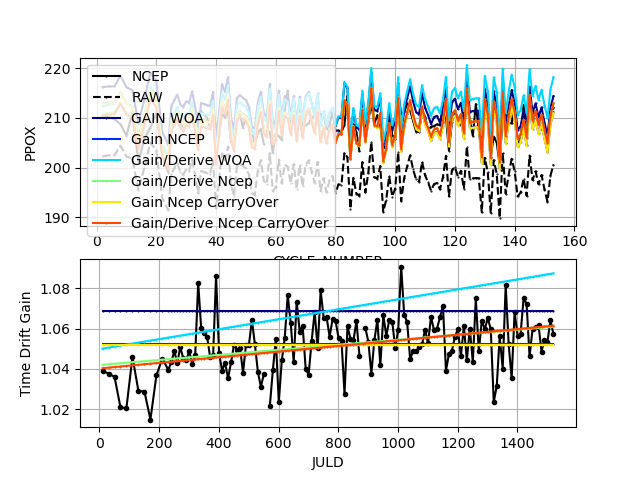

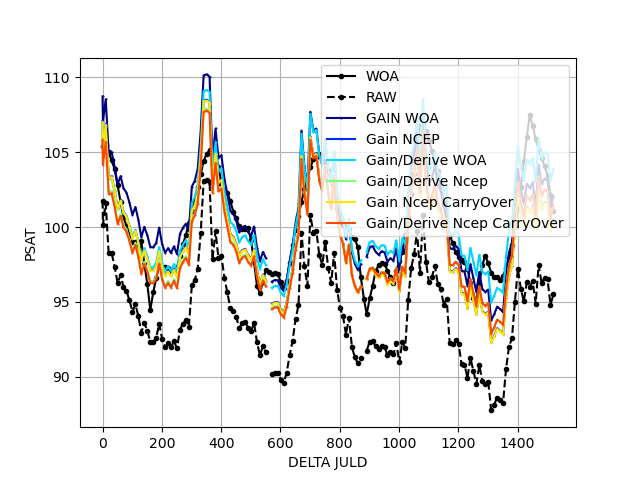

In [87]:
# Compare NCEP and WOA with the correction (without piece)
dict_corr = {'GAIN WOA' : params_Gain_WOA,'Gain NCEP' : params_Gain_NCEP,'Gain/Derive WOA' : params_Gain_Derive_WOA,
             'Gain/Derive Ncep' : params_Gain_Derive_NCEP,'Gain Ncep CarryOver' : params_Gain_NCEP_CarryOver,'Gain/Derive Ncep CarryOver' : params_Gain_Derive_NCEP_CarryOver}
deltaT_list=[[]] * len(dict_corr)
_=plot_cmp_corr_NCEP(dict_corr,deltaT_list,dsair,NCEP_PPOX,delta_T_NCEP)
#_=plot_cmp_corr_NCEP_old(dict_corr,dsair,NCEP_PPOX,delta_T_NCEP)
#_=plot_cmp_corr_WOA_old(dict_corr, ds_argo_interp, ds_woa_interp, delta_T_WOA)
_=plot_cmp_corr_WOA(dict_corr, deltaT_list,ds_argo_interp, ds_woa_interp, delta_T_WOA)

Correction :  [1.04015606 0.49142909]
Pressure effect Estimation
[1.01790568]
[0.00785416]
[1.00831514]


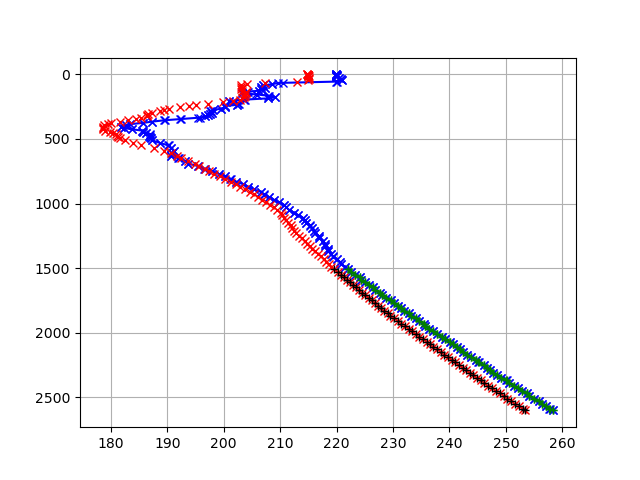

In [94]:
# Which correction to keep/apply
params_to_keep =copy.deepcopy(params_Gain_Derive_NCEP_CarryOver)
#params_to_keep =copy.deepcopy(params_Gain_NCEP_CarryOver)

print(f'Correction :  {params_to_keep}')


# Init Pressure correction (0 by default) and a supplement gain form CTD (1 by default)
params_no_corr_pressure = np.array([0])
params_Gain_CTD = np.array([1])
params_Gain_CTD_with_pressure = np.array([1])
params_corr_pressure = np.array([0])

oxy_ctd_tot = np.array([])
cycle_corr_tot = np.array([])
pres_corr_tot = np.array([])
oxy_pour_pres_tot = np.array([])
pres_pour_pres_tot = np.array([])
cycle_pour_pres_tot = np.array([])

# Compare ARGO Profil  with  CTD. We compare PPOX
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)

        ana_dens = sw.pden(ds_cruise['PSAL'],ds_cruise['TEMP'],ds_cruise['PRES'],0)
        O2_ARGO_umolL = umolkg_to_umolL(ds_cruise['OXYK'],ds_cycle['DOXY'].units,ana_dens)
        ppox_cruise = O2ctoO2p(O2_ARGO_umolL,ds_cruise['TEMP'],ds_cruise['PSAL'],ds_cruise['PRES']) # On calcule PPOX pour P=0
        oxy_ctd_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ppox_cruise[0])
        oxy_ctd_tot = np.concatenate((oxy_ctd_tot,oxy_ctd_interp),axis=None)

        delta_T_Sprof = diff_time_in_days(ds_cycle['JULD'].values,launch_date)
        tab_delta_T= np.tile(delta_T_Sprof,(1,len(ds_cycle['N_LEVELS'])))

         

        ana_dens = sw.pden(ds_cycle['PSAL_ADJUSTED'],ds_cycle['TEMP_ADJUSTED'],ds_cycle['PRES_ADJUSTED'],0)
        O2_ARGO_umolL = umolkg_to_umolL(ds_cycle['DOXY'],ds_cycle['DOXY'].units,ana_dens)
        ppox_ARGO = O2ctoO2p(O2_ARGO_umolL,ds_cycle['TEMP_ADJUSTED'],ds_cycle['PSAL_ADJUSTED'],ds_cycle['PRES_ADJUSTED']) # On calcule PPOX pour P=0
        ppox_ARGO_corr = model_Gain_Derive([ppox_ARGO,tab_delta_T],*params_to_keep)
        #ppox_ARGO_corr = model_Gain(ppox_ARGO,*params_to_keep)
        cycle_corr_tot = np.concatenate((cycle_corr_tot,ppox_ARGO_corr),axis=None)
        pres_corr_tot = np.concatenate((pres_corr_tot,ds_cycle['PRES'].isel(N_PROF=0).values),axis=None)
 

        # Information for pressure effect correction
        PRES_1D = ds_cycle['PRES'].squeeze()  
        mask = PRES_1D >= pressure_threshold
        pres_pour_pres_tot = np.concatenate((pres_pour_pres_tot,ds_cycle['PRES'].sel(N_LEVELS=mask)),axis=None)
        oxy_pour_pres_tot = np.concatenate((oxy_pour_pres_tot,oxy_ctd_interp[0][mask.values]),axis=None)   
        cycle_pour_pres_tot = np.concatenate((cycle_pour_pres_tot,ppox_ARGO_corr[0][mask.values]),axis=None)




    plt.figure()
    _=plt.plot(oxy_ctd_tot,pres_corr_tot,'x-b')
    _=plt.plot(cycle_corr_tot,pres_corr_tot,'x-r')
    _=plt.plot(cycle_pour_pres_tot,pres_pour_pres_tot,'+-k')
    _=plt.plot(oxy_pour_pres_tot,pres_pour_pres_tot,'+-g')
    plt.gca().invert_yaxis()
    plt.grid()

    # Solution without pressure correction
    # CTD Gain estimation
    initial_guess = 0
    params_Gain_CTD, covariance = curve_fit(model_Gain, cycle_corr_tot, oxy_ctd_tot, p0=initial_guess,nan_policy='omit')
    # Solution with pressure effect correction
    print('Pressure effect Estimation')
    initial_guess = [0]   
    params_corr_pressure, covariance = curve_fit(model_corr_pres, [cycle_pour_pres_tot,pres_pour_pres_tot], oxy_pour_pres_tot, p0=initial_guess,nan_policy='omit') 
    cycle_corr_tot = model_corr_pres([cycle_corr_tot,pres_corr_tot],*params_corr_pressure)
    initial_guess = 0
    # CTD Gain estimation with pressure effect correction
    params_Gain_CTD_with_pressure, covariance = curve_fit(model_Gain, cycle_corr_tot, oxy_ctd_tot, p0=initial_guess,nan_policy='omit')

   # _=plt.plot(cycle_corr*params_Gain_CTD[0],ds_cycle['PRES'],'.-c')


print(params_Gain_CTD)
print(params_corr_pressure)
print(params_Gain_CTD_with_pressure)

In [95]:
derive_final = 0

if len(params_to_keep) == 1:
    derive_final = 0
else :
    derive_final = params_to_keep[1]
    
gain_final = params_Gain_CTD[0] * params_to_keep[0]
corr_final_without_pressure_correction = np.array([gain_final,derive_final,params_no_corr_pressure[0]])
gain_final_with_pressure = params_Gain_CTD_with_pressure[0] * params_to_keep[0]
corr_final_with_pressure_correction = np.array([gain_final_with_pressure,derive_final,params_corr_pressure[0]])


print(f'Final Correction without pressure effect : {corr_final_without_pressure_correction}')
print(f'Final Correction with pressure effect : {corr_final_with_pressure_correction}')

Final Correction without pressure effect : [1.05878076 0.49142909 0.        ]
Final Correction with pressure effect : [1.0488051  0.49142909 0.00785416]


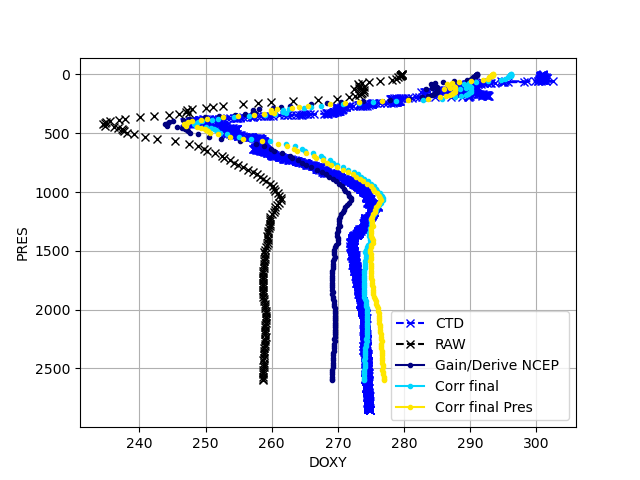

In [96]:
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
        dict_corr = {'Gain/Derive NCEP ' : params_to_keep,'Corr final' :corr_final_without_pressure_correction,'Corr final Pres' :corr_final_with_pressure_correction}
        
        _=plot_cmp_ARGO_CTD(ds_cruise,ds_cycle,dict_corr,launch_date) 

        

In [97]:
#
# Which correction to apply (without or with pressure correction).
#
corr_final_to_use = corr_final_without_pressure_correction

val_bid = os.path.join(rep_data_argo,num_float,'profiles','B?' +num_float + '_???.nc')
fic_argo = glob.glob(val_bid)
fic_argo.sort()
#
# Modifier pour ne corriger que les cycles entre first cycle et last cycle ?...
# A faire seulement si saut dans les donnees ???
#
rep_fic_res = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/locodox_python/fic_netcdf_test'
comment_corr = 'Adjustement made with NCEP for Gain/Drift  + Gain with CTD'
for i_fic in range(0,len(fic_argo)):
    fic_en_cours = fic_argo[i_fic]
    fic_res = os.path.join(rep_fic_res,os.path.basename(fic_en_cours))
    fic_res = fic_res.replace('BR','BD',1)
    ds = xr.open_dataset(fic_en_cours,engine='argo')
    cycle_en_cours = ds['CYCLE_NUMBER'].values[0]
    juld_en_cours = ds['JULD'].values[0]
    delta_T_en_cours = diff_time_in_days(juld_en_cours,launch_date)
    if (cycle_en_cours >= first_cycle_to_use) & (cycle_en_cours<=last_cycle_to_use):
        coef_pres = corr_final_to_use[2]
        gain_final = corr_final_to_use[0]
        derive_final = corr_final_to_use[1]  
        coef_corr = f'INCLINE_T=0, SLOPE={gain_final}, DRIFT={derive_final}, COEF_PRES ={coef_pres},OFFSET=0.000000, DRIFT2=0.000000'
        eq_corr = 'DOXY2 = (1 +coef_press *PRES/1000) * DOXY,DOXY_ADJUSTED=OFFSET+(SLOPE*(1+DRIFT/100.*(profile_date_juld-launch_date_juld)/365+DRIFT2/100.*(profile_date_juld-launch_date_juld)**2/365**2)+INCLINE_T*TEMP)*DOXY2'
        print(f'Correction de {fic_en_cours} avec {corr_final_to_use}')
        if os.path.exists(fic_res):
            os.remove(fic_res)
        corr_file(fic_en_cours,fic_res,launch_date,comment_corr,coef_corr,eq_corr,gain_final,derive_final,coef_pres,percent_relative_error)

Correction de /Volumes/ref-argo/gdac/dac/coriolis/6902882/profiles/BD6902882_001.nc avec [1.05878076 0.49142909 0.        ]
Correction de /Volumes/ref-argo/gdac/dac/coriolis/6902882/profiles/BD6902882_002.nc avec [1.05878076 0.49142909 0.        ]
Correction de /Volumes/ref-argo/gdac/dac/coriolis/6902882/profiles/BD6902882_003.nc avec [1.05878076 0.49142909 0.        ]
Correction de /Volumes/ref-argo/gdac/dac/coriolis/6902882/profiles/BD6902882_004.nc avec [1.05878076 0.49142909 0.        ]
Correction de /Volumes/ref-argo/gdac/dac/coriolis/6902882/profiles/BD6902882_005.nc avec [1.05878076 0.49142909 0.        ]
Correction de /Volumes/ref-argo/gdac/dac/coriolis/6902882/profiles/BD6902882_006.nc avec [1.05878076 0.49142909 0.        ]
Correction de /Volumes/ref-argo/gdac/dac/coriolis/6902882/profiles/BD6902882_007.nc avec [1.05878076 0.49142909 0.        ]
Correction de /Volumes/ref-argo/gdac/dac/coriolis/6902882/profiles/BD6902882_008.nc avec [1.05878076 0.49142909 0.        ]
Correcti

In [98]:
delta_T_en_cours

1520.6211805555527